In [21]:
from salad.serialize import read
import matplotlib.pyplot as plt

In [64]:
recovery[]

{726689: {'points': {},
  'line': {},
  'catalog': {'fake': 1,
   'total': 104,
   'coords': <SkyCoord (ICRS): (ra, dec) in deg
       [(216.68268993, -12.89975166)]>,
   'time': <Column name='time' dtype='float64' length=1>
   58577.367808049545,
   'snr': <Column name='significance' dtype='float64' length=1>
   0.23562641441822052},
  'info': {'vra': <Quantity -0.02580475 deg / d>,
   'vdec': <Quantity 0.00744039 deg / d>,
   'closest_dir': <Quantity [-0.01044277,  0.0035723 ] deg / d>,
   'min_dv': <Quantity 0.01584148 deg / d>,
   'distance': <Quantity 0.00282579 deg>,
   'findable': False}},
 14649253: {'points': {},
  'line': {},
  'catalog': {'fake': 30,
   'total': 33,
   'coords': <SkyCoord (ICRS): (ra, dec) in deg
       [(216.63023152, -12.85928182), (216.62973598, -12.85942085),
        (216.62895659, -12.85982918), (216.62840738, -12.85992372),
        (216.62798176, -12.86014287), (216.62758391, -12.86025044),
        (216.62714679, -12.86044371), (216.62668024, -12.86066

In [85]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.table

def make_results(f, recovery, vmin, vmax, phimin, phimax):
    results = []

    for g in f.group_by("ORBITID").groups:
        idx = np.argsort(g['EXPNUM'])
        binary = len(g) != len(set(g['EXPNUM']))

        g = g[idx]
        orbit = g[0]['ORBITID']
        mag = g['MAG'].mean()
        c = SkyCoord(g['RA'] * u.deg, g['DEC'] * u.deg)
        c_0 = c[0]
        c_1 = c[-1]
        dt = (g[-1]['mjd_mid'] - g[0]['mjd_mid'])*u.day
        v = (c_1.separation(c_0) / dt).to(u.deg/u.day)
        phi = np.arctan2(c_1.dec - c_0.dec, c_1.ra - c_0.ra).to(u.deg)
        findable = False
        if v > vmin and v < vmax:
            if phi > phimin and phi < phimax:
                findable = True

        found = (
            (len(recovery[orbit]['line']) > 0) 
            and 
            any([l['fake']/l['total'] > 0.5 for k, l in recovery[orbit]['line'].items()])
        )
        results.append(
            {
                "orbit": orbit,
                "v": v,
                "phi": phi,
                "findable": findable,
                "mag": mag,
                "found": found,
                "detected": recovery[orbit]['catalog']['fake'],
                "binary": binary,
            }
        )

    results = astropy.table.Table(results)
    return results

def wilson_score_interval(z_alpha, n_s, n_f):
    n = n_s + n_f
    m = (n_s + 0.5 * z_alpha**2) / (n + z_alpha**2)
    u = ((z_alpha) / (n + z_alpha**2)) *  ((n_s*n_f/n) + (z_alpha**2)/4)**0.5
    return m - u, m + u

def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10, mag_col='mag', found_col='found'):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog[mag_col] >= lower) & (catalog[mag_col] < upper)]
        if len(a) > 0:
            num_recovered = a[found_col].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            l, u = wilson_score_interval(1, num_recovered, num_possible - num_recovered)
            errors.append([num_recovered/num_possible - l, u - num_recovered/num_possible])
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, np.array(errors).T

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as autograd_np

def p(m, c, k, m_50):
    return c / (1 + autograd_np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return autograd_np.log(c) - autograd_np.log(1 + autograd_np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return autograd_np.sum(log_p(recovered_mag, c, k, m_50)) + autograd_np.sum(autograd_np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return (
        autograd_np.sum(autograd_np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        autograd_np.sum(autograd_np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results, mag_col='mag', found_col='found'):
    recovered_mag = results[results[found_col]][mag_col].value
    missed_mag = results[~results[found_col]][mag_col].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = autograd_np.sqrt(autograd_np.diag(autograd_np.linalg.inv(hess)))
        else:
            fit_std = autograd_np.array([autograd_np.nan, autograd_np.nan, autograd_np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d

In [128]:
# vmin = 0.008 * u.deg/u.day
# vmax = 0.012 * u.deg/u.day
# phimin = 158 * u.deg
# phimax = 162 * u.deg
vmin = 0.00158 * u.deg/u.day
vmax = 0.02113 * u.deg/u.day
phimin = 151.23 * u.deg
phimax = 168.70 * u.deg

snr_results = {}
for snr in [0.0, 1.0, 2.0]:
    t = []
    for detector in range(1, 63):
        if detector in [2, 32, 61]:
            continue
        fakes = read(f"/epyc/projects/salad/search/new/DEEP/20190403/A0c/detector_{detector}/fakes.pkl")
        f = fakes[fakes['type'] == 'tno']
        recovery = read(f"/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/regular/tno/deduplicated_recovery.pkl")

        r = make_results(f, recovery, vmin, vmax, phimin, phimax)
        r['detector'] = detector
        t.append(r)

    results = astropy.table.vstack(t)
    snr_results[snr] = results

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [129]:
snr_results[0.0]

orbit,v,phi,findable,mag,found,detected,binary,detector
,deg / d,deg,,,,,,
int64,float64,float64,bool,float64,bool,int64,bool,int64
2405372,0.019558461629477754,168.39825700754162,True,24.573885428055313,False,70,False,1
2732908,0.012082481222041624,161.52027795964636,True,25.68617649738313,False,0,False,1
3881210,0.009545628956146747,161.1472486254834,True,26.306819324841076,False,40,False,1
3898678,0.014735776461058392,162.3771570720673,True,26.47601778348476,False,7,False,1
4279478,0.012096529156942875,155.47319226296221,True,24.78000547555636,True,57,False,1
5182786,0.00814373039496204,154.64506986598138,True,26.158283666804156,False,22,False,1
5485151,0.0006330107597850406,160.07987686781578,False,24.156122049911747,False,7,False,1
5962014,0.013612382654722257,163.04163601016464,True,24.547227600193064,True,68,False,1


In [104]:
results[results['found']]['v'].min(), results[results['found']]['v'].max()

(0.0015874482009591573, 0.02113250903307142)

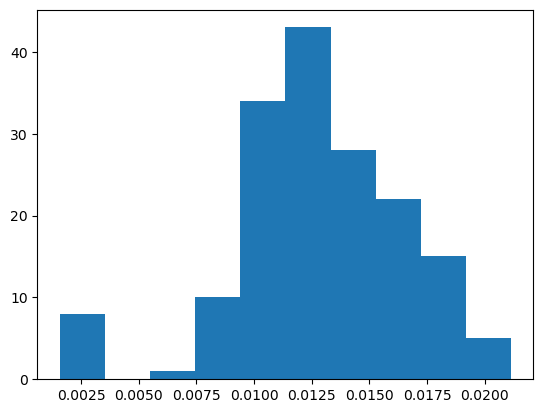

In [106]:
plt.hist(results[results['found']]['v'])
plt.show()

In [107]:
results[results['found'] & (results['phi'] > 0)]['phi'].min(), results[results['found']]['phi'].max()

(151.2345693408199, 168.69884764385642)

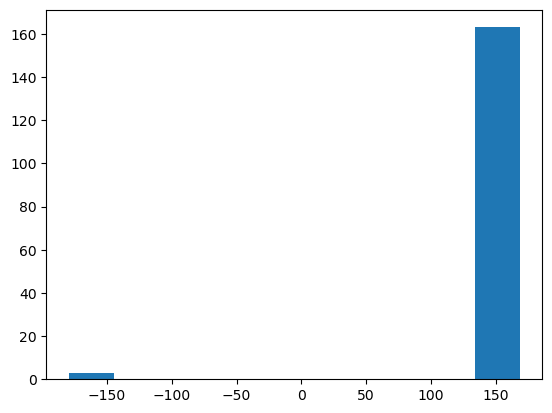

In [108]:
plt.hist(results[results['found']]['phi'])
plt.show()

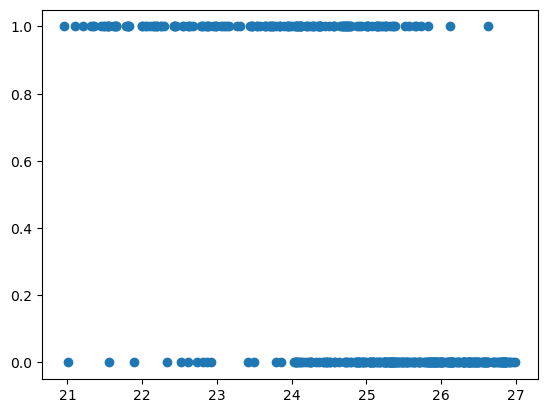

In [134]:
results = snr_results[0.0]
r = results[results['findable'] | results['found']]
plt.scatter(r['mag'], r['found'])
plt.show()

In [110]:
r

orbit,v,phi,findable,mag,found,detected,binary,detector
,deg / d,deg,,,,,,
int64,float64,float64,bool,float64,bool,int64,bool,int64
2405372,0.019558461629477754,168.39825700754162,True,24.573885428055313,False,70,False,1
2732908,0.012082481222041624,161.52027795964636,True,25.68617649738313,False,0,False,1
3881210,0.009545628956146747,161.1472486254834,True,26.306819324841076,False,40,False,1
3898678,0.014735776461058392,162.3771570720673,True,26.47601778348476,False,7,False,1
4279478,0.012096529156942875,155.47319226296221,True,24.78000547555636,True,57,False,1
5182786,0.00814373039496204,154.64506986598138,True,26.158283666804156,False,22,False,1
5962014,0.013612382654722257,163.04163601016464,True,24.547227600193064,True,68,False,1
6009903,0.014750418844791795,167.89854794126813,True,26.851329609695888,False,0,False,1


In [84]:
# the best filter is probably to look at the rates of what was found to construct a bound
# the completeness is entirely dependent on how you classify what is findable
# it's complicated because we find objects that technically should not be findable

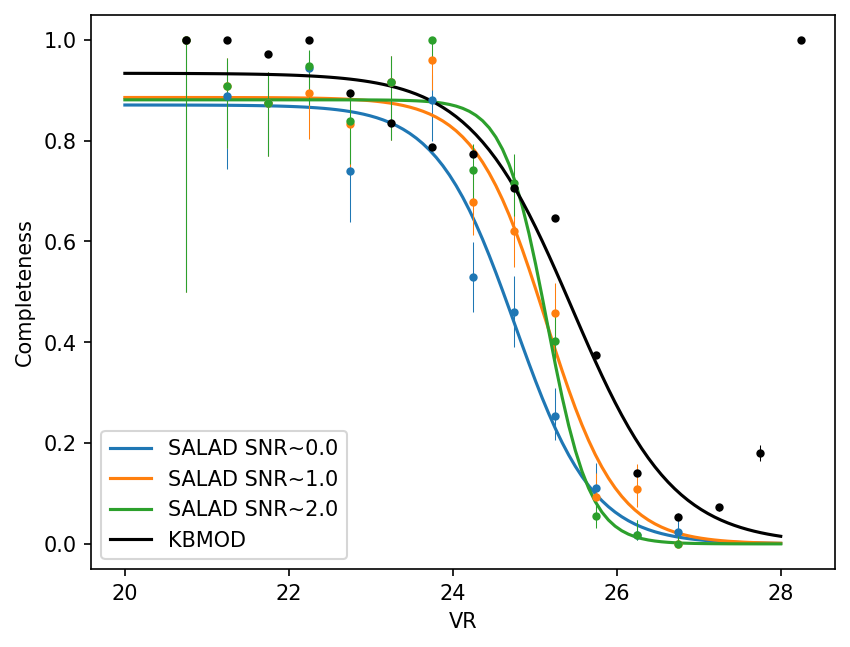

In [138]:
fit_result_kbmod = {'c': 0.9337558694755008,
  'k': 1.6155916626198876,
  'm_50': 25.456359434396326,
  'sigma_c': 0.0027025522988996433,
  'sigma_k': 0.018616425624865682,
  'sigma_m_50': 0.00781360056071236}

plt.figure(dpi=150)

_x = np.linspace(20, 28, 100)
for i, snr in enumerate(snr_results):
    results = snr_results[snr]
    r = results[results['findable'] | results['found']]

    bin_detection(r, 21, 27)

    _t = r
    fit_result = do_fit(_t, found_col='found')
    x, y, yerr = bin_detection(_t, _x.min(), _x.max(), dm=0.5, found_col='found')
    _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

    kbmod_result = kbmod_results['20190403_A0c']


    plt.plot(_x, _y, color=f'C{i}', label=f"SALAD SNR~{snr}")
    plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C{i}")

_y_kbmod = p(_x, kbmod_result['fit']['c'], kbmod_result['fit']['k'], kbmod_result['fit']['m_50'])
plt.plot(_x, _y_kbmod, color=f'k', label="KBMOD")    
plt.errorbar(kbmod_result['x'], kbmod_result['y'], yerr=kbmod_result['yerr'], fmt='o', lw=0.5, ms=3, c=f"k")

plt.ylabel("Completeness")
plt.xlabel("VR")
# plt.title(f"SNR>=0")
plt.legend()
# plt.savefig("figures/kbmod_vs_salad.png")
# plt.savefig("figures/kbmod_vs_salad.pdf")
plt.show()

In [139]:
fit_result['m_50']

25.149223047386393

In [140]:
10**(-(fit_result['m_50'] - 23.5)*2/5)*5 # effective SNR

1.0946638730134448

In [50]:
import json

In [51]:
with open("/epyc/projects/kbmod/runs/DEEP/xmatch_catalogs/fitres_per_night_per_stare.json") as f:
    kbmod_results = json.load(f)

In [123]:
kbmod_results['20190403_A0c']['fit']['m_50'] - fit_result['m_50']

0.700052951875918

In [69]:
kbmod_result['x']

[20.75,
 21.25,
 21.75,
 22.25,
 22.75,
 23.25,
 23.75,
 24.25,
 24.75,
 25.25,
 25.75,
 26.25,
 26.75,
 27.25,
 27.75,
 28.25]